# Growth of decision-consistent and stimulus-specific biases

In [1]:
import os
import sys
import pickle

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from statsmodels.stats.weightstats import DescrStatsW

from sklearn.linear_model import LinearRegression
from scipy.linalg import expm

sys.path.append('..')
from src import utils
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/outputs/behavior")

with open("../data/outputs/behavior/results_stimulus_specific_bias.pickle", 'rb') as f:
    results = pickle.load(f)

downloading data/outputs/behavior...
data/outputs/behavior already exists. Skipping download...


In [3]:
from src.model_ddm import model
sys.modules['model'] = model
model_path = '../models/ddm/'

In [4]:
models_full = {}
models_rdcd = {}

# full model
files  = sorted([f for f in os.listdir(model_path+'full') if ('.pkl' in f)])
for v_f in files:
    with open(model_path+'full/'+v_f, 'rb') as f:
        models_full[v_f[17:21]] = pickle.load(f)
    
# reduced model
files  = sorted([f for f in os.listdir(model_path+'reduced') if ('.pkl' in f)])
for v_f in files:
    with open(model_path+'reduced/'+v_f, 'rb') as f:
        models_rdcd[v_f[17:21]] = pickle.load(f)

In [5]:
def forward(model, params, data):
    # parameters
    if model.model == 'full':    
        w_K = params[0]*np.pi/90.
    w_E, w_P, w_D, w_r, w_b = [p*np.pi/90. for p in params[(-7):(-2)]]
    lam, c = params[(-2):]

    # efficient encoding 
    kappa = model.kappa
    p,F = model.efficient_encoding(c)
    p_e = np.sqrt(1./np.clip(w_E,model.eps,None))
    F_interp = model.F_interp(F)
    P0  = np.exp(p_e*(np.cos((F.reshape(-1,1)-F_interp(data['stim'])))-1.))    
    P0  = P0*p.reshape(-1,1)
    P0 /= P0.sum(axis=0,keepdims=True)
    
    # transition matrices
    Lp = model.Hdiffu/2.*np.power(w_P,2) # production transition
    if model.model == 'reduced':    
        L = model.Hdiffu/2.*np.power(w_D,2)
    elif model.model == 'full':
        L = model.Hdiffu/2.*np.power(w_D,2) - model.Hdrift@np.diag(kappa*w_K)

    # density propagation
    P  = [np.zeros_like(P0)*np.nan, np.zeros_like(P0)*np.nan] # CW, CCW
    PE = [np.zeros_like(P0) * np.nan, np.zeros_like(P0) * np.nan] 
    PL = [np.zeros_like(P0) * np.nan, np.zeros_like(P0) * np.nan]
    L1 = [L*model.delay[0][0], L*model.delay[0][1]] # 1st delay transitions for Early and Late conditions
    L2 = [L*model.delay[1][0], L*model.delay[1][1]] # 2nd delay transitions for Early and Late conditions

    for i_delay, delay in enumerate(model.delay_condition):
        _P      = expm(L1[i_delay]) @ P0
        _P_cw   = (1.-lam) * model.mask_cw * _P + lam * model.mask_ccw * _P
        _P_ccw  = lam * model.mask_cw * _P + (1.-lam) * model.mask_ccw * _P
        for r in model.relative_reference:
            idx = (data['delay']==delay) & (data['relref']==r)
            P[0][:, idx] = expm(Lp) @ expm(L2[i_delay]) @ expm(model.Hdrift*(-w_b*(np.abs(r)<model.near_cutoff)-r*w_r)) @ _P_cw[:,idx]
            P[1][:, idx] = expm(Lp) @ expm(L2[i_delay]) @ expm(model.Hdrift*( w_b*(np.abs(r)<model.near_cutoff)-r*w_r)) @ _P_ccw[:,idx]
               
            if delay == 1:
                PE[0][:,idx] = _P_cw[:,idx]
                PE[1][:,idx] = _P_ccw[:,idx]
            if delay == 2:
                PL[0][:,idx] = _P_cw[:,idx]
                PL[1][:,idx] = _P_ccw[:,idx]

    # Make nonnegative
    P[0][P[0]<0] = 0.; P[1][P[1]<0] = 0.
    PE[0][PE[0]<0] = 0.; PE[1][PE[1]<0] = 0.
    PL[0][PL[0]<0] = 0.; PL[1][PL[1]<0] = 0.

    # 
    sums  = (P[0]+P[1]).sum(axis=0,keepdims=True)
    P[0] /= sums
    P[1] /= sums
    sums  = (PE[0]+PE[1]).sum(axis=0,keepdims=True)
    PE[0] /= sums
    PE[1] /= sums
    sums  = (PL[0]+PL[1]).sum(axis=0,keepdims=True)
    PL[0] /= sums
    PL[1] /= sums

    return PE, PL, P

In [6]:
# may take about 2mins
bias_weights = np.zeros((2,50,2)) * np.nan
dcb_res      = np.zeros((2,50,2,2)) * np.nan # E-L / CW-CCW
dcb_ref_ref  = np.zeros((2,50,2,5,2)) * np.nan # E-L / CW-CCW
bdms         = np.zeros((2,50,24,2)) * np.nan

for i_models, models in enumerate([models_full, models_rdcd]):
    for i_model, (n_model, model) in enumerate(models.items()):
        # average densities over diffferent stimuli and choices
        errsD = np.zeros((2,5,96,24,2)) * np.nan
        errsE = np.zeros((2,5,96,24,2)) * np.nan

        fitted_params = model.fitted_params.copy()
        _stim = np.linspace(0,180,num=24,endpoint=False)

        for i_d, v_d in enumerate([1,2]):
            _delay  = np.ones(24) * v_d
            for i_r, v_r in enumerate([-21,-4,0,4,21]):
                _relref = np.repeat(v_r, 24)
                _ref    = (_stim + v_r - 90.) % (180.) - 90.
                _data   = {
                    'deg' : {
                        'stim': _stim,
                        'ref' : _ref
                    },
                    'relref': _relref,
                    'delay' : _delay
                }
                _data = model.convert_unit(_data)
                model.gen_mask(_data)
                PE, PL, P = forward(model, fitted_params, _data)
                errsD[i_d,i_r,:,:,0] = np.stack([np.roll(p,-i*4) for i,p in enumerate([PE,PL][i_d][0].T)],axis=-1)
                errsD[i_d,i_r,:,:,1] = np.stack([np.roll(p,-i*4) for i,p in enumerate([PE,PL][i_d][1].T)],axis=-1)
                errsE[i_d,i_r,:,:,0] = np.stack([np.roll(p,-i*4) for i,p in enumerate(P[0].T)],axis=-1)
                errsE[i_d,i_r,:,:,1] = np.stack([np.roll(p,-i*4) for i,p in enumerate(P[1].T)],axis=-1)

        # make early and late decision-period biases
        s = np.sin(model.m); c = np.cos(model.m)
        s, c = [errsD.sum(axis=-1).mean(axis=1).transpose((0,2,1)) @ v for v in [s,c]]
        b_dm = np.arctan2(s,c)
        bdms[i_models,i_model,:,0] = b_dm[0]
        bdms[i_models,i_model,:,1] = b_dm[1]

        # make estimation period bias
        s = np.sin(model.m); c = np.cos(model.m)
        s, c = [errsE.sum(axis=-1).mean(axis=1).transpose((0,2,1)) @ v for v in [s,c]]
        b_em = np.arctan2(s,c).mean(axis=0)

        # calculate bias weights using intercept-free linear regression (unnormalized)
        stims_vec = np.arange(180,step=7.5)
        ssb  = utils.stimulus_specific_bias(stims_vec, results['weights'][int(n_model)], **results['info'])
        ssb *= np.pi/90
        bias_weights[i_models,i_model,0] = LinearRegression(fit_intercept=True).fit(ssb.reshape(-1,1),b_dm[0]).coef_[0]
        bias_weights[i_models,i_model,1] = LinearRegression(fit_intercept=True).fit(ssb.reshape(-1,1),b_dm[1]).coef_[0]

        # 
        s = np.sin(model.m)
        c = np.cos(model.m)
        s,c = [errsE[:,1:4].mean(axis=(1,3)).transpose((0,2,1)) @ k for k in [s,c]]
        bb = np.arctan2(s,c)
        dcb_res[i_models,i_model] = bb * 90/np.pi

        # 
        s = np.sin(model.m)
        c = np.cos(model.m)
        s,c = [errsE[:,:].mean(axis=3).transpose((0,1,3,2)) @ k for k in [s,c]]
        bb = np.arctan2(s,c) # [2,5,2]
        dcb_ref_ref[i_models,i_model] = bb * 90/np.pi

---
## Stimulus-specific bias 

Full


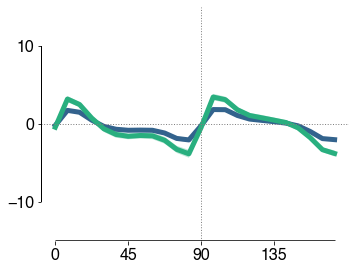

Reduced


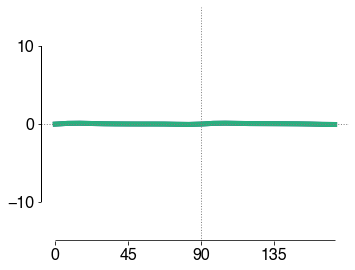

In [7]:
for i_model, v_model in enumerate(['Full', 'Reduced']):
    print( v_model )
    stims = np.arange(180,step=7.5)
    mE, sE = np.mean(bdms[i_model,:,:,0]*90/np.pi,axis=0), np.std(bdms[i_model,:,:,0]*90/np.pi,axis=0)/np.sqrt(50)
    mL, sL = np.mean(bdms[i_model,:,:,1]*90/np.pi,axis=0), np.std(bdms[i_model,:,:,1]*90/np.pi,axis=0)/np.sqrt(50)

    plt.figure()
    ax = plt.gca()
    utils.set_size([4,3])

    plt.plot(stims, mE, color='#33638D',linewidth=5.)
    plt.plot(stims, mL, color='#29AF7F',linewidth=5.)

    plt.axvline(x=90, linestyle='dotted', color='gray', linewidth=1.)
    plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)
    plt.fill_between(x=stims, y1=mE-sE, y2=mE+sE, color='#33638D', alpha=0.3, edgecolor="none")
    plt.fill_between(x=stims, y1=mL-sL, y2=mL+sL, color='#29AF7F', alpha=0.3, edgecolor="none")
    plt.ylim([-15,15])

    if utils.LABEL:
        plt.xlabel(r"Stimulus $(\!\!^\circ\!\!)$")    
        plt.ylabel(r"Bias at $t_\mathrm{DM}$ $(\!\!^\circ\!\!)$")
    fign = ['g','k'][i_model]
    utils.draw_publish_axis(ax, xrange=(0,172.5), yrange=(-10,10), xticks=[0,45,90,135], yticks=[-10,0,10])
    plt.savefig(f'{utils.DIR_FIGURE}/fig4{fign}.pdf', bbox_inches='tight')
    plt.show()

Full
Bias weight: Early vs. Late

Paired samples t-test
t(49)= 22.501391713619793 p= 1.7478305929567415e-27
95% CI= (0.21204424293064425, 0.2536334167985058)

Wilcoxon signed-rank test (without continuity correction)
V= 0.0 p= 7.556929455863566e-10


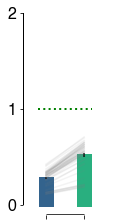

Reduced
Bias weight: Early vs. Late

Paired samples t-test
t(49)= 1.0834714823027276 p= 0.2839019264435666
95% CI= (-6.1367543643652044e-18, 2.0495833100389273e-17)

Wilcoxon signed-rank test (without continuity correction)
V= 119.0 p= 0.1512581946793469


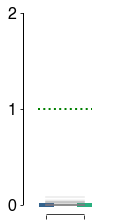

In [8]:
for i_model, v_model in enumerate(['Full', 'Reduced']):
    print( v_model )

    plt.figure()
    ax = plt.gca()
    utils.set_size([1.4,2.5])

    v_E, v_L = bias_weights[i_model,:,0], bias_weights[i_model,:,1]
    ms = [np.mean(v_E), np.mean(v_L)]
    ss = [np.std(v_E)/np.sqrt(50), np.std(v_L)/np.sqrt(50)]
    for i in range(50):
        plt.plot([-1,1.5], [v_E[i],v_L[i]], color='gray', alpha=0.09)

    bar = plt.bar(x=[-1,1.5], height=ms, color=["#33638D", "#29AF7F"])
    bar[0].set_edgecolor('#33638D')
    bar[1].set_edgecolor('#29AF7F')
    bar[0].set_linewidth(3)
    bar[1].set_linewidth(3)
    plt.errorbar(x=[-1,1.5], y=ms, yerr=ss, fmt="none", color="k")

    plt.xlim([-2.5,3])
    plt.ylim([-0.1,2])
    plt.xticks([-1,1.5], ['Early', 'Late'])
    ax.hlines(y=1, xmin=-1.5, xmax=2, linestyle='dotted', color='green', linewidth=2.)

    if utils.LABEL:
        plt.ylabel(r"Bias weight", labelpad=10)

    ttest  = DescrStatsW(v_L-v_E)
    wilcox = wilcoxon(v_L-v_E)
    print("Bias weight: Early vs. Late")
    print('\nPaired samples t-test')
    print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
    print('95% CI=', ttest.tconfint_mean())
    print('\nWilcoxon signed-rank test (without continuity correction)')
    print('V=', wilcox[0], 'p=', wilcox[1])

    plt.xticks([-1,1.5], ['', ''])
    fign = ['h','l'][i_model]
    utils.draw_publish_axis(ax, xrange=(-1,1.5), yrange=(0,2), xticks=None, yticks=[0,1,2])
    plt.savefig(f'{utils.DIR_FIGURE}/fig4{fign}.pdf', bbox_inches='tight')
    plt.show()

---
## Decision-consistent bias 

Full
Decision-consistent bias: Early vs. Late

Paired samples t-test
t(49)= 11.601110786832512 p= 1.1607672771260918e-15
95% CI= (1.3712953725521102, 1.9459106059131803)

Wilcoxon signed-rank test (without continuity correction)
V= 0.0 p= 7.556929455863566e-10


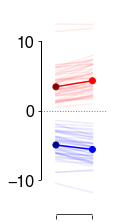

Reduced
Decision-consistent bias: Early vs. Late

Paired samples t-test
t(49)= 4.231854485285132 p= 0.00010126705863774305
95% CI= (0.29902220403119817, 0.839825179686266)

Wilcoxon signed-rank test (without continuity correction)
V= 0.0 p= 0.00043777719457466354


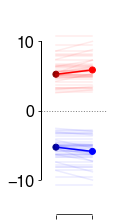

In [9]:
for i_model, v_model in enumerate(['Full', 'Reduced']):
    print( v_model )
    
    plt.figure()
    ax = plt.gca()
    utils.set_size([1.4,2.5])

    v_Ecw  = dcb_res[i_model,:,0,1]
    v_Eccw = dcb_res[i_model,:,0,0]
    v_Lcw  = dcb_res[i_model,:,1,1]
    v_Lccw = dcb_res[i_model,:,1,0]

    v_Lcw[np.abs(v_Ecw-v_Lcw)<1e-4]    = v_Ecw[np.abs(v_Ecw-v_Lcw)<1e-4]
    v_Lccw[np.abs(v_Eccw-v_Lccw)<1e-4] = v_Eccw[np.abs(v_Eccw-v_Lccw)<1e-4]

    ms_cw  = [np.median(v_Ecw), np.median(v_Lcw)]
    ss_cw  = [np.std(v_Ecw)/np.sqrt(50), np.std(v_Lcw)/np.sqrt(50)]
    ms_ccw = [np.median(v_Eccw), np.median(v_Lccw)]
    ss_ccw = [np.std(v_Eccw)/np.sqrt(50), np.std(v_Lccw)/np.sqrt(50)]

    plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)

    plt.errorbar(x=[-1], y=ms_cw[0], yerr=ss_cw[0], fmt="none", color="darkblue")
    plt.errorbar(x=[1.5], y=ms_cw[-1], yerr=ss_cw[-1], fmt="none", color="blue")
    plt.scatter(x=[-1,1.5], y=ms_cw, color=["darkblue", "blue"])
    for i in range(50):
        plt.plot([-1,1.5], [v_Ecw[i],v_Lcw[i]], color='blue', alpha=0.08)

    plt.scatter(x=[-1,1.5], y=ms_ccw, color=["darkred", "red"])
    plt.errorbar(x=[-1], y=ms_ccw[0], yerr=ss_ccw[0], fmt="none", color="darkred")
    plt.errorbar(x=[1.5], y=ms_ccw[-1], yerr=ss_ccw[-1], fmt="none", color="red")
    for i in range(50):
        plt.plot([-1,1.5], [v_Eccw[i],v_Lccw[i]], color='red', alpha=0.08)  

    plt.plot([-1,1.5], [ms_cw[0], ms_cw[-1]],   color='blue', zorder=0)
    plt.plot([-1,1.5], [ms_ccw[0], ms_ccw[-1]], color='red', zorder=0)
    plt.xlim([-2,2.5])
    plt.ylim([-15,15])

    ttest  = DescrStatsW((v_Lccw-v_Lcw)-(v_Eccw-v_Ecw))
    wilcox = wilcoxon((v_Lccw-v_Lcw)-(v_Eccw-v_Ecw))
    print("Decision-consistent bias: Early vs. Late")
    print('\nPaired samples t-test')
    print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
    print('95% CI=', ttest.tconfint_mean())
    print('\nWilcoxon signed-rank test (without continuity correction)')
    print('V=', wilcox[0], 'p=', wilcox[1])

    if utils.LABEL:
        plt.ylabel(r"Estimation error $(\!\!^\circ\!\!)$")    
        plt.xticks([-1,1.5], ['Early', 'Late'])
    else:
        plt.xticks([-1,1.5], ['', ''])
    utils.draw_publish_axis(ax, xrange=(-1,1.5), yrange=(-10,10), xticks=None, yticks=[-10,0,10])
    fign = ['f','j'][i_model]
    plt.savefig(f'{utils.DIR_FIGURE}/fig4{fign}.pdf', bbox_inches='tight')
    plt.show()

In [10]:
%%capture
dcb_list = np.nan*np.empty([2,2,5,2,50])
for i_model in range(2):
    for s_r in range(5):
        dcb_list[i_model,:,s_r] = dcb_ref_ref[i_model,:,:,4-s_r].transpose((1,2,0))
        
dcb_list[:,:,0,0] = np.nan
dcb_list[:,:,4,1] = np.nan
m_dcb_list = np.nanmedian(dcb_list,axis=-1)
s_dcb_list = np.nanstd(dcb_list,axis=-1)/np.sqrt(50) * 1.96

Full


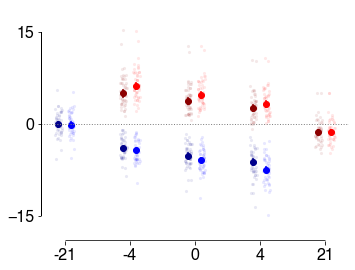

Reduced


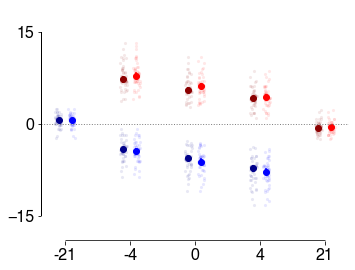

In [11]:
for i_model, v_model in enumerate(['Full', 'Reduced']):
    print( v_model )
    
    plt.figure()
    ax = plt.gca()
    utils.set_size([4,3])

    devi = 0.1
    plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)

    # Early
    plt.scatter(np.array([-2,-1,0,1,2])-devi, (m_dcb_list)[i_model,0,:,1], color='darkblue')
    plt.vlines( np.array([-2,-1,0,1,2])-devi, (m_dcb_list-s_dcb_list)[i_model,0,:,1], 
                                              (m_dcb_list+s_dcb_list)[i_model,0,:,1], color='darkblue')
    for i_r, v_r in enumerate([-2,-1,0,1,2]):    
        plt.scatter( np.array([v_r]*50)-devi+ np.random.uniform(-devi/2,devi/2,size=50), 
                     dcb_list[i_model,0,i_r,1,:], color='darkblue', alpha=0.09, linewidth=0, s=10, zorder=0)

    plt.scatter(np.array([-2,-1,0,1,2])-devi, (m_dcb_list)[i_model,0,:,0], color='darkred')
    plt.vlines( np.array([-2,-1,0,1,2])-devi, (m_dcb_list-s_dcb_list)[i_model,0,:,0], 
                                              (m_dcb_list+s_dcb_list)[i_model,0,:,0], color='darkred')
    for i_r, v_r in enumerate([-2,-1,0,1,2]):    
        plt.scatter( np.array([v_r]*50)-devi+ np.random.uniform(-devi/2,devi/2,size=50), 
                     dcb_list[i_model,0,i_r,0,:], color='darkred', alpha=0.09, linewidth=0, s=10, zorder=0)

    # Late
    plt.scatter(np.array([-2,-1,0,1,2])+devi, (m_dcb_list)[i_model,1,:,1], color='blue')
    plt.vlines( np.array([-2,-1,0,1,2])+devi, (m_dcb_list-s_dcb_list)[i_model,1,:,1], 
                                              (m_dcb_list+s_dcb_list)[i_model,1,:,1], color='blue')
    for i_r, v_r in enumerate([-2,-1,0,1,2]):    
        plt.scatter( np.array([v_r]*50)+devi+ np.random.uniform(-devi/2,devi/2,size=50), 
                     dcb_list[i_model,1,i_r,1,:], color='blue', alpha=0.09, linewidth=0, s=10, zorder=0)

    plt.scatter(np.array([-2,-1,0,1,2])+devi, (m_dcb_list)[i_model,1,:,0], color='red')
    plt.vlines( np.array([-2,-1,0,1,2])+devi, (m_dcb_list-s_dcb_list)[i_model,1,:,0], 
                                              (m_dcb_list+s_dcb_list)[i_model,1,:,0], color='red')
    for i_r, v_r in enumerate([-2,-1,0,1,2]):    
        plt.scatter( np.array([v_r]*50)+devi+ np.random.uniform(-devi/2,devi/2,size=50), 
                     dcb_list[i_model,1,i_r,0,:], color='red', alpha=0.09, linewidth=0, s=10, zorder=0)

    plt.ylim([-19,19])
    plt.xticks([-2,-1,0,1,2],[-21,-4,0,4,21])
    utils.draw_publish_axis(ax, xrange=(-2,2), yrange=(-15,15), xticks=None, yticks=[-15,0,15])
    fign = ['e','i'][i_model]
    plt.savefig(f'{utils.DIR_FIGURE}/fig4{fign}.pdf', bbox_inches='tight')
    plt.show()